In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger as TensorBoardLogger
import tensorboard


import numpy as np
from lstm_second import BasicLSTM
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, r'C:\Users\Spenc\Documents\GitHub\itcs-8156\utils')

from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

In [3]:

def makepred(model, dataset):
    y = []
    t = []
    for ii in dataset:
        feat, lab = ii

        y.append(model.forward(feat).detach().numpy()[0])
        t.append(lab.numpy()[0])


    return y, t

def scatter_results(Y,T,title):
    plt.figure(figsize=(9,9))
    plt.scatter(Y,T)
    plt.xlabel('Model Prediction')
    plt.ylabel('True Value')
    plt.title(title)

In [ ]:
# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 
f = r'G:\My Drive\School\UNCC\P.h.D\Coursework\2023 - SPRING\ITCS 8156 - Machine Learning\Project\archive'
X_train, X_test, T_train, T_test = market_prepro(f,st,sn,False,splitdata=True, stdzr='minmax')

print(X_train.shape)
print(T_train.shape)
# X,T = market_prepro(f,st,sn,False,splitdata=False)

actfn1 = ['Sigmoid', 'arcsinh', 'Mish', 'ReLU',  'SELU', 'LeakyReLU']
actfn2 = ['tanh', 'tanh', 'Sigmoid', 'Sigmoid', 'Sigmoid', 'ELU']

test_days = [2, 3, 5, 7, 10, 15, 20]
results_daysweep = []

for i in range(len(actfn1)):

    act1fn1=actfn1[i]
    act2fn2=actfn2[i]

    for j in range(len(test_days)):
        #number of days as features
        day_feat = test_days[j]

        #number of days to use as features
        day_targ = 1
        day_targ = day_targ - 1

        # dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train[['Open','Low']], T_train, 4, 1,None)
        # dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test[['Open','Low']], T_test, 4, 1,  None)

        dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train, T_train, day_feat, day_targ, [ 'Year', 'Month' ,'Day_date', 'Day'])
        dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test, T_test, day_feat, day_targ, [ 'Year', 'Month' ,'Day_date', 'Day'])

        mdl_stock = BasicLSTM(num_feat=7, num_hiddens=1, num_out=1, lr=0.01, actfn1=act1fn1, actfn2=act2fn2)
        mdl_stock.forward(ds_train[0][0])

        logger = TensorBoardLogger("lightning_logs", name="market")
        trainer = pl.Trainer(max_epochs=5,logger=logger) # with default learning rate, 0.001 (this tiny learning rate makes learning slow)
        trainer.fit(mdl_stock, train_dataloaders=dl_train)
        trainer.test(mdl_stock,dataloaders=dl_test)
        torch.save(mdl_stock, act1fn1+act2fn2+str(day_feat))

        y_test, t_test = makepred(mdl_stock, ds_test)
        y_train, t_train = makepred(mdl_stock, ds_train)

        train_score = r2_score(t_train, y_train)
        test_score = r2_score(t_test, y_test)

        add_res_sweep = [act1fn1, act2fn2, day_feat, train_score, test_score]

        results_daysweep.append(add_res_sweep)

torch.save(results_daysweep, 'Day Input Sweep Results')

In [4]:
results_daysweep= torch.load('Day Input Sweep Results')
sweep = pd.DataFrame(results_daysweep)
display(sweep.sort_values(4, ascending=False))

,0,1,2,3,4
7,ReLU,Sigmoid,2,9.964232e-01,9.995326e-01
1,SELU,Sigmoid,3,9.986789e-01,9.987521e-01
23,Mish,Sigmoid,2,9.950963e-01,9.980370e-01
8,ReLU,Sigmoid,3,9.947467e-01,9.970694e-01
10,ReLU,Sigmoid,7,9.873537e-01,9.954643e-01
36,arcsinh,tanh,20,9.966052e-01,9.950838e-01
28,Mish,Sigmoid,15,9.927007e-01,9.943357e-01
5,SELU,Sigmoid,15,9.947209e-01,9.934700e-01
12,ReLU,Sigmoid,15,9.882363e-01,9.923348e-01
13,ReLU,Sigmoid,20,9.901664e-01,9.912368e-01


Text(0, 0.5, 'r2 score')

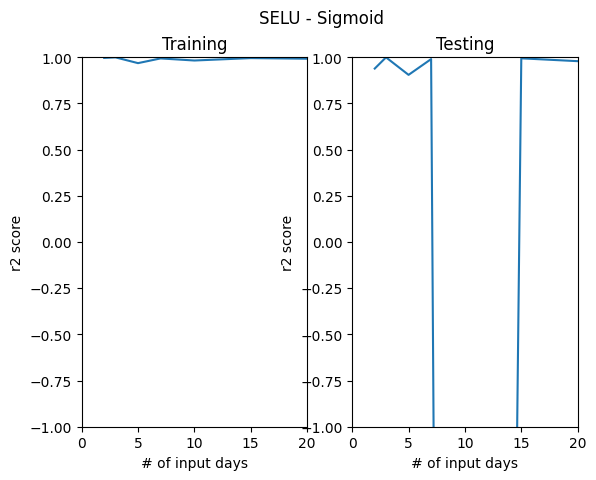

In [5]:
sweep_res=pd.DataFrame(results_daysweep)
train_sweep = sweep_res.where(sweep_res[0] == 'SELU').dropna()
plt.figure()
plt.suptitle('SELU - Sigmoid')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

Text(0, 0.5, 'r2 score')

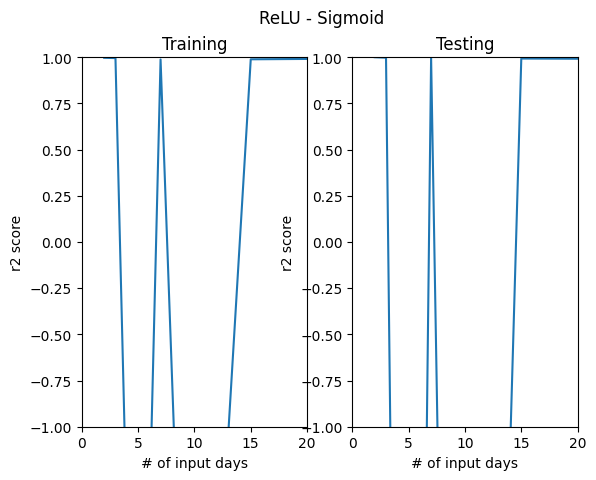

In [6]:
train_sweep = sweep_res.where(sweep_res[0] == 'ReLU').dropna()
plt.figure()
plt.suptitle('ReLU - Sigmoid')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

Text(0, 0.5, 'r2 score')

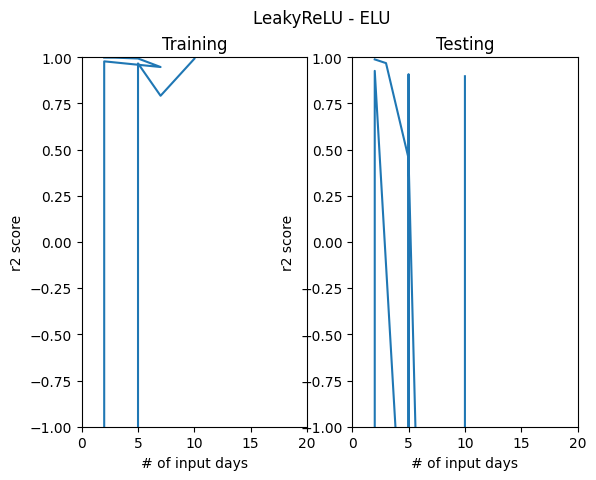

In [7]:
train_sweep = sweep_res.where(sweep_res[0] == 'LeakyReLU').dropna()
plt.figure()
plt.suptitle('LeakyReLU - ELU')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([-1,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

Text(0, 0.5, 'r2 score')

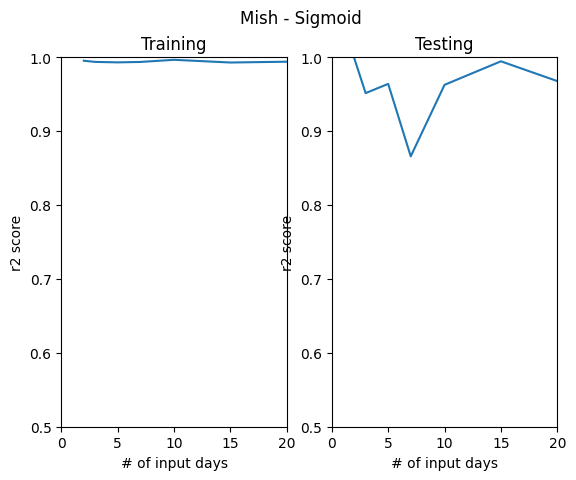

In [8]:
train_sweep = sweep_res.where(sweep_res[0] == 'Mish').dropna()
plt.figure()
plt.suptitle('Mish - Sigmoid')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

Text(0, 0.5, 'r2 score')

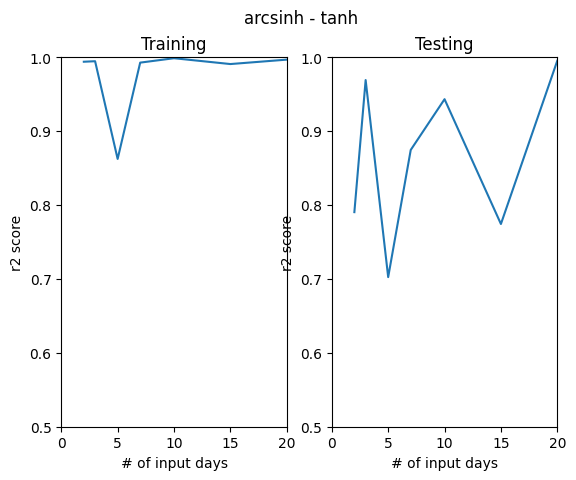

In [9]:
train_sweep = sweep_res.where(sweep_res[0] == 'arcsinh').dropna()
plt.figure()
plt.suptitle('arcsinh - tanh')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

C:\Users\Spenc\AppData\Local\Temp\ipykernel_18392\3963620977.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


Text(0, 0.5, 'r2 score')

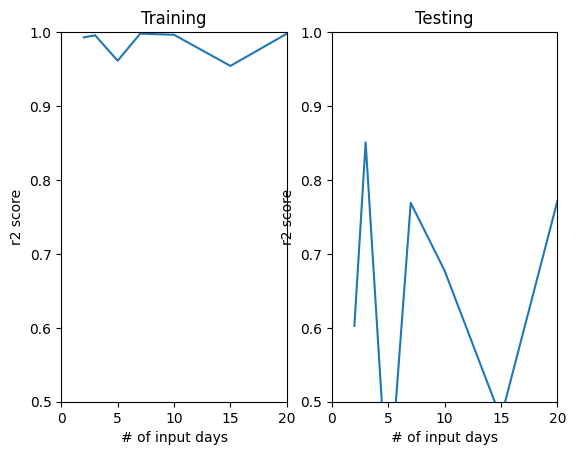

In [10]:
train_sweep = sweep_res.where(sweep_res[0] == 'Sigmoid').dropna()
plt.figure()
plt.title('Sigmoid - tanh or BASE LSTM')
plt.subplot(121)
plt.plot(train_sweep[2], train_sweep[3])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Training')
plt.xlabel('# of input days')
plt.ylabel('r2 score')

plt.subplot(122)
plt.plot(train_sweep[2], train_sweep[4])
plt.xlim([0,20])
plt.ylim([0.5,1])
plt.title('Testing')
plt.xlabel('# of input days')
plt.ylabel('r2 score')